# Diabetes Risk Prediction
This project uses the Behavioral Risk Factor Surveillance System (BRFSS) survey data from [this link](https://www.cdc.gov/brfss/annual_data/annual_2024.html) to predict the probability of developing different types of Diabetes. Features about U.S. residents include demographic data (e.g. income level, education, race) as well as data regarding health-related risk behaviors, chronic health conditions, and use of preventive services.

This is the **second notebook** for the project, which reads the dataframe created by the `parse_raw_data.ipynb` notebook, performs exploratory data analysis (EDA), and develops a predictive model for assessing Diabetes risk. If all goes well, I will try to add multiclass prediction to include Prediabetes risk. The primary target variable for this study will be the DIABETE4 column in the dataframe (i.e. "(Ever told) you had diabetes"), which includes Prediabetes as a separate class. This dataset is highly imbalanced so will require additional effort to train the model effectively. Note that the other two Diabetes related columns (PREDIAB2 and DIABTYPE) have been included for validation purposes, and for potential future study.

There are 26 candidate features included in the input dataframe. EDA and modeling evaluation will likely reduce this number. The final columns used for the predictive model will be listed here when they have been selected.

The input dataset contains 2 identifier columns, 3 Target variable candidates and a total of 26 potential features. Each column name is provided below with their column name in the dataframe (i.e. SAS variable name and their human-readable label from the HTML file)
- Each row is uniquely defined by (i.e. Table's Grain)
  1. "State FIPS Code" -> _STATE
  2. "Annual Sequence Number" -> SEQNO
- Target variable candidates related to Diabetes include
  1. "(Ever told) you had diabetes" -> DIABETE4
  2. "Ever been told by a doctor or other health professional that you have pre-diabetes or borderline diabetes?" -> PREDIAB2
  3. "What type of diabetes do you have?" -> DIABTYPE
- Demographic features include
  1. "Urban/Rural Status" -> _URBSTAT
  2. "Reported age in five-year age categories calculated variable" -> _AGEG5YR
  3. "Sex of Respondent" -> SEXVAR
  4. "Computed Race-Ethnicity grouping" -> _RACE
  5. "Education Level" -> EDUCA
  6. "Income Level" -> INCOME3
- Personal health features include
  1. "Have Personal Health Care Provider?" -> PERSDOC3
  2. "Could Not Afford To See Doctor" -> MEDCOST1
  3. "Computed Weight in Kilograms" -> WTKG3
  4. "Computed Height in Meters" -> HTM4
  5. "Computed body mass index" -> _BMI5
  6. "Exercise in Past 30 Days" -> EXERANY2
  7. "How often did you drink regular soda or pop that contains sugar?" -> SSBSUGR2
  8. "How often did you drink sugar-sweetened drinks?" -> SSBFRUT3
  9. "Computed Smoking Status" -> _SMOKER3
  10. "Computed number of drinks of alcohol beverages per week" -> _DRNKWK3
  11. "Drink any alcoholic beverages in past 30 days" -> DRNKANY6
  12. "Heavy Alcohol Consumption  Calculated Variable" -> _RFDRHV9
  13. "General Health" -> GENHLTH
- Other disease indicator features include
  1. "Ever Diagnosed with Heart Attack" -> CVDINFR4
  2. "Ever Diagnosed with Angina or Coronary Heart Disease" -> CVDCRHD4
  3. "Ever Diagnosed with a Stroke" -> CVDSTRK3
  4. "Ever told you have kidney disease?" -> CHCKDNY2
  5. "Ever Told Had Asthma" -> ASTHMA3
  6. "(Ever told) you had a depressive disorder" -> ADDEPEV3
  7. "Told Had Arthritis" -> HAVARTH4

**Notes**
- Target variable is imbalanced so I will need to use stratified train/validation/test splitting. Stretch goal would be to stratify by State as well to make sure that each split is evenly distributed across the country...

## Setup
### Define parameters
The input/output parameters are defined in the next cell. The columns to remove, `cols_to_remove`, are updated at the end of the EDA section to obtain the final features used to train the model candidates in the Model Selection section.

In [1]:
input_data_file = "diabetes_data.pickle"
target_col = "DIABETE4"
target_val = "Yes"
cols_to_remove = [
    "PREDIAB2",
    "DIABTYPE",
    "SSBSUGR2",
    "SSBFRUT3",
    "DRNKANY6",
    "_RFDRHV9"
]
categorical_features = [
    "_URBSTAT",
    "SEXVAR",
    "_RACE",
    "PERSDOC3",
    "MEDCOST1",
    "EXERANY2",
    "_SMOKER3",
    "CVDINFR4",
    "CVDCRHD4",
    "CVDSTRK3",
    "CHCKDNY2",
    "ASTHMA3",
    "ADDEPEV3",
    "HAVARTH4"
]
ordinal_features = [
    "_AGEG5YR",
    "EDUCA",
    "INCOME3",
    "GENHLTH"
]
numeric_features = [
    "WTKG3",
    "HTM4",
    "_BMI5",
    "_DRNKWK3"
]
val_ratio = .2
test_ratio = .2

### Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score, roc_auc_score, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels
import xgboost as xgb

pd.set_option('display.max_columns', None)

### Define Functions

In [3]:
def clean_target(df, target_col, target_val, verbose=True):
    """
    Clean and encode target variable.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    target_col : str
        Name of target column
    target_val : str
        Positive class value (will be encoded as 1)
    verbose : bool
        Print summary statistics
    
    Returns:
    --------
    pd.DataFrame : DataFrame with cleaned and encoded target
    """
    df_clean = df.copy()
    
    # Filter to valid target values only
    rows_before = len(df_clean)
    df_clean = df_clean[(df_clean[target_col] == "Yes") | (df_clean[target_col] == "No")]
    rows_after = len(df_clean)
    
    # Encode target as binary
    df_clean[target_col] = (df_clean[target_col] == target_val).astype(int)
    
    if verbose:
        print(f"Target variable cleaning ({target_col}):")
        print(f"  Rows removed (invalid target): {rows_before - rows_after:,}")
        print(f"  Rows remaining: {rows_after:,}")
        print(f"\nClass distribution:")
        class_dist = df_clean[target_col].value_counts(normalize=True).sort_index()
        for val, pct in class_dist.items():
            label = target_val if val == 1 else f"Not {target_val}"
            print(f"  {val} ({label}): {pct:.2%}")
    
    return df_clean


def clean_features(df, categorical_features, ordinal_features, numeric_features, verbose=True):
    """
    Clean all features: categorical, ordinal, and numeric.
    
    For categorical/ordinal: map NaN and "Refused" to "Unknown"
    For numeric: create missing indicators and impute with median
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    categorical_features : list
        List of categorical feature column names
    ordinal_features : list
        List of ordinal feature column names
    numeric_features : list
        List of numeric feature column names
    verbose : bool
        Print summary statistics
    
    Returns:
    --------
    pd.DataFrame : DataFrame with cleaned features and missing indicator columns
    """
    df_clean = df.copy()
    
    # === Clean categorical and ordinal features ===
    features_to_clean = categorical_features + ordinal_features
    
    for col in features_to_clean:
        if col in df_clean.columns:
            # Fill NaN values with "Unknown"
            df_clean[col] = df_clean[col].fillna("Unknown")
            # Replace "Refused" with "Unknown"
            df_clean[col] = df_clean[col].replace("Refused", "Unknown")
    
    if verbose:
        # Verify categorical/ordinal cleaning
        missing_counts = df_clean[features_to_clean].isnull().sum()
        missing_counts = missing_counts[missing_counts > 0]
        if len(missing_counts) > 0:
            print("Missing value counts after cleaning categorical/ordinal features:")
            print(missing_counts)
        else:
            print("✓ No missing values in categorical/ordinal features after cleaning")
        
        # Show 'Unknown' counts sorted by percentage
        print("\n'Unknown' counts per feature (sorted by percentage):")
        unknown_data = []
        for col in features_to_clean:
            unknown_count = (df_clean[col] == "Unknown").sum()
            if unknown_count > 0:
                unknown_data.append({
                    'Feature': col,
                    'Count': unknown_count,
                    'Percent': unknown_count/len(df_clean)*100
                })
        
        # Sort by percentage descending
        unknown_data.sort(key=lambda x: x['Percent'], reverse=True)
        
        for item in unknown_data:
            print(f"  {item['Feature']}: {item['Count']:,} ({item['Percent']:.2f}%)")
    
    # === Clean numeric features ===
    if verbose:
        # Show missing counts before processing
        print("\n" + "="*60)
        print("Missing values in numeric features before processing:")
        missing_data = []
        for col in numeric_features:
            missing_count = df_clean[col].isnull().sum()
            if missing_count > 0:
                missing_data.append({
                    'Feature': col,
                    'Count': missing_count,
                    'Percent': missing_count/len(df_clean)*100
                })
        
        # Sort by percentage descending
        missing_data.sort(key=lambda x: x['Percent'], reverse=True)
        
        for item in missing_data:
            print(f"  {item['Feature']}: {item['Count']:,} ({item['Percent']:.2f}%)")
    
    # Create missing indicator columns
    if verbose:
        print("\nCreating missing indicator columns...")
    
    for col in numeric_features:
        indicator_col = f'{col}_missing'
        df_clean[indicator_col] = df_clean[col].isnull().astype(int)
        if verbose:
            print(f"  Created {indicator_col}")
    
    # Impute missing values with median
    if verbose:
        print("\nImputing missing values with median...")
    
    for col in numeric_features:
        median_val = df_clean[col].median()
        missing_count = df_clean[col].isnull().sum()
        if missing_count > 0:
            df_clean[col] = df_clean[col].fillna(median_val)
            if verbose:
                print(f"  {col}: imputed {missing_count:,} values with median = {median_val:.2f}")
    
    if verbose:
        # Verify no missing values remain
        print("\n✓ Verification:")
        remaining_missing = df_clean[numeric_features].isnull().sum().sum()
        print(f"  Missing values remaining in numeric features: {remaining_missing}")
        print(f"  Missing indicator columns created: {len([col for col in df_clean.columns if col.endswith('_missing')])}")
    
    return df_clean


def split_train_val_test(df, val_ratio=.2, test_ratio=.2, stratify=None, r_seed=1, verbose=False):
    """Use the train_test_split function from sklearn to split input dataframe
    into randomly shuffled train, validation, and test datasets with the
    validation dataset containing val_ratio of the input data and the test
    dataset containing test_ratio of the input data. Stratify, if provided, is 
    the name of the column in df to use when stratifying the splits.
    """
    n = len(df)
    # Generate test dataset
    strat_col = stratify
    if stratify:
        strat_col = df[stratify]
    full_train_df, test_df = train_test_split(df, test_size=test_ratio, stratify=strat_col, random_state=r_seed)
    test_df = test_df.reset_index(drop=True)
    # Generate train, validation, and test splits
    val_ft_ratio = val_ratio / (1 - test_ratio)
    if stratify:
        strat_col = full_train_df[stratify]
    train_df, val_df = train_test_split(full_train_df, test_size=val_ft_ratio, stratify=strat_col, random_state=r_seed)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(train_df) + len(val_df) + len(test_df) == len(df)}")
    return train_df, val_df, test_df


def calculate_mi_scores(df, categorical_features, ordinal_features, target_col):
    """
    Calculate mutual information scores for categorical and ordinal features.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    categorical_features : list
        List of categorical feature column names
    ordinal_features : list
        List of ordinal feature column names
    target_col : str
        Name of target column
    
    Returns:
    --------
    pd.DataFrame : DataFrame with features and their MI scores, sorted by score descending
    """
    all_features = categorical_features + ordinal_features
    mi_scores = []
    
    for feature in all_features:
        score = mutual_info_score(df[feature], df[target_col])
        mi_scores.append({'feature': feature, 'mi_score': score})
    
    mi_df = pd.DataFrame(mi_scores).sort_values('mi_score', ascending=False).reset_index(drop=True)
    return mi_df


def calculate_numeric_correlations(df, numeric_features, target_col):
    """
    Calculate Pearson correlations for numeric features with target.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    numeric_features : list
        List of numeric feature column names
    target_col : str
        Name of target column
    
    Returns:
    --------
    pd.DataFrame : DataFrame with features and their correlation with target, sorted by absolute value descending
    """
    correlations = []
    
    for feature in numeric_features:
        corr = df[feature].corr(df[target_col])
        correlations.append({'feature': feature, 'correlation': corr, 'abs_correlation': abs(corr)})
    
    corr_df = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False).reset_index(drop=True)
    return corr_df[['feature', 'correlation']]


def calculate_vif(df, numeric_features):
    """
    Calculate Variance Inflation Factor for numeric features.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    numeric_features : list
        List of numeric feature column names
    
    Returns:
    --------
    pd.DataFrame : DataFrame with features and their VIF values, sorted by VIF descending
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    # Create subset with only numeric features
    X = df[numeric_features].values
    
    vif_data = []
    for i, feature in enumerate(numeric_features):
        vif = variance_inflation_factor(X, i)
        vif_data.append({'feature': feature, 'VIF': vif})
    
    vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False).reset_index(drop=True)
    return vif_df


def calculate_diabetes_rate(df, feature, target_col):
    """
    Calculate diabetes prevalence rate for each category in a feature.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    feature : str
        Feature column name
    target_col : str
        Target column name
    
    Returns:
    --------
    pd.DataFrame : DataFrame with categories and diabetes rates, sorted by rate descending
    """
    rates = df.groupby(feature)[target_col].agg(['sum', 'count', 'mean'])
    rates.columns = ['diabetes_count', 'total_count', 'diabetes_rate']
    rates = rates.sort_values('diabetes_rate', ascending=False).reset_index()
    return rates

## Load data
### Input dataframe

In [4]:
input_df = pd.read_pickle(input_data_file)

In [5]:
display(input_df.head())
display(input_df.info())

,_STATE,SEQNO,DIABETE4,PREDIAB2,DIABTYPE,_URBSTAT,_AGEG5YR,SEXVAR,_RACE,EDUCA,INCOME3,PERSDOC3,MEDCOST1,WTKG3,HTM4,_BMI5,EXERANY2,SSBSUGR2,SSBFRUT3,_SMOKER3,_DRNKWK3,DRNKANY6,_RFDRHV9,GENHLTH,CVDINFR4,CVDCRHD4,CVDSTRK3,CHCKDNY2,ASTHMA3,ADDEPEV3,HAVARTH4
0,Alabama,2024000001,No,NaN,NaN,"Urban counties (_URBNRRL = 1,2,3,4,5)",Age 75 to 79,Female,"White only, non-Hispanic",Grade 12 or GED (High school graduate),Refused,More than one,No,59.42,1.63,22.49,Yes,NaN,NaN,Never smoked,0.0,No,No,Good,No,No,No,No,No,No,Yes
1,Alabama,2024000002,No,NaN,NaN,"Urban counties (_URBNRRL = 1,2,3,4,5)",Age 80 or older,Male,"White only, non-Hispanic",College 4 years or more (College graduate),"$200,000 or more","Yes, only one",No,81.65,1.78,25.83,Yes,NaN,NaN,Former smoker,0.0,No,No,Excellent,No,Yes,No,No,No,No,Yes
2,Alabama,2024000003,No,NaN,NaN,"Urban counties (_URBNRRL = 1,2,3,4,5)",Age 55 to 59,Male,"White only, non-Hispanic",College 1 year to 3 years (Some college or tec...,Refused,No,Yes,88.45,1.98,22.53,Yes,NaN,NaN,Current smoker - now smokes every day,14.0,Yes,No,Very good,No,No,No,No,No,No,Yes
3,Alabama,2024000004,No,NaN,NaN,"Urban counties (_URBNRRL = 1,2,3,4,5)",Age 80 or older,Male,"White only, non-Hispanic",College 4 years or more (College graduate),"Less than $50,000 ($35,000 to < $50,000)","Yes, only one",No,74.84,1.73,25.09,Yes,NaN,NaN,Never smoked,0.0,No,No,Excellent,No,No,No,No,No,No,Yes
4,Alabama,2024000005,No,NaN,NaN,"Urban counties (_URBNRRL = 1,2,3,4,5)",Age 45 to 49,Male,"White only, non-Hispanic",College 1 year to 3 years (Some college or tec...,"Less than $20,000 ($15,000 to < $20,000)","Yes, only one",No,58.97,1.73,19.77,No,NaN,NaN,Never smoked,0.0,No,No,Good,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 457656 entries, 0 to 457669
Data columns (total 31 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    457656 non-null  object 
 1   SEQNO     457656 non-null  object 
 2   DIABETE4  457652 non-null  object 
 3   PREDIAB2  159191 non-null  object 
 4   DIABTYPE  13818 non-null   object 
 5   _URBSTAT  443033 non-null  object 
 6   _AGEG5YR  457656 non-null  object 
 7   SEXVAR    457656 non-null  object 
 8   _RACE     457656 non-null  object 
 9   EDUCA     457649 non-null  object 
 10  INCOME3   448387 non-null  object 
 11  PERSDOC3  457653 non-null  object 
 12  MEDCOST1  457650 non-null  object 
 13  WTKG3     421264 non-null  float64
 14  HTM4      433599 non-null  float64
 15  _BMI5     414632 non-null  float64
 16  EXERANY2  457653 non-null  object 
 17  SSBSUGR2  115597 non-null  object 
 18  SSBFRUT3  115311 non-null  object 
 19  _SMOKER3  457656 non-null  object 
 20  _DRNKWK3 

None

## Preprocessing
All preprocessing steps are now in reusable functions to prevent issues when re-running cells.

### Clean target variable
Filter to valid target values and encode as binary (0/1)

In [6]:
pp_df = clean_target(input_df, target_col=target_col, target_val=target_val, verbose=True)

Target variable cleaning (DIABETE4):
  Rows removed (invalid target): 15,736
  Rows remaining: 441,920

Class distribution:
  0 (Not Yes): 85.11%
  1 (Yes): 14.89%


### Clean all features
Single function that cleans categorical, ordinal, and numeric features:
- **Categorical/Ordinal**: Map NaN and "Refused" to "Unknown"
- **Numeric**: Create missing indicators and impute with median

**Note:** WTKG3, HTM4, and _BMI5 are likely highly correlated (BMI is calculated from weight and height). One or more will likely be removed during EDA feature correlation analysis.

In [7]:
pp_df = clean_features(
    pp_df, 
    categorical_features=categorical_features,
    ordinal_features=ordinal_features,
    numeric_features=numeric_features,
    verbose=True
)

✓ No missing values in categorical/ordinal features after cleaning

'Unknown' counts per feature (sorted by percentage):
  INCOME3: 84,077 (19.03%)
  _SMOKER3: 30,911 (6.99%)
  _URBSTAT: 13,958 (3.16%)
  _RACE: 8,649 (1.96%)
  _AGEG5YR: 7,971 (1.80%)
  PERSDOC3: 4,363 (0.99%)
  CVDCRHD4: 4,080 (0.92%)
  CVDINFR4: 2,770 (0.63%)
  ADDEPEV3: 2,332 (0.53%)
  HAVARTH4: 2,194 (0.50%)
  EDUCA: 2,193 (0.50%)
  CHCKDNY2: 1,665 (0.38%)
  ASTHMA3: 1,567 (0.35%)
  MEDCOST1: 1,513 (0.34%)
  GENHLTH: 1,204 (0.27%)
  EXERANY2: 1,184 (0.27%)
  CVDSTRK3: 1,184 (0.27%)

Missing values in numeric features before processing:
  _DRNKWK3: 45,122 (10.21%)
  _BMI5: 41,321 (9.35%)
  WTKG3: 35,049 (7.93%)
  HTM4: 23,088 (5.22%)

Creating missing indicator columns...
  Created WTKG3_missing
  Created HTM4_missing
  Created _BMI5_missing
  Created _DRNKWK3_missing

Imputing missing values with median...
  WTKG3: imputed 35,049 values with median = 80.74
  HTM4: imputed 23,088 values with median = 1.70
  _BMI5: im

### Train/Validation/Test Splits

In [8]:
train_df, val_df, test_df = split_train_val_test(pp_df, val_ratio=val_ratio, test_ratio=test_ratio, stratify=target_col, verbose=True)

All rows in the original dataframe are contained within the training, validation, or test datasets: True


## EDA
### Target variable

In [9]:
# Calculate mutual information scores for categorical and ordinal features
mi_scores = calculate_mi_scores(train_df, categorical_features, ordinal_features, target_col)
print("Mutual Information Scores (Categorical & Ordinal Features):")
print("="*60)
display(mi_scores)

Mutual Information Scores (Categorical & Ordinal Features):


,feature,mi_score
0,GENHLTH,0.035167
1,_AGEG5YR,0.032654
2,HAVARTH4,0.014400
3,CHCKDNY2,0.012085
4,CVDCRHD4,0.010132
5,EXERANY2,0.010126
6,PERSDOC3,0.009606
7,CVDINFR4,0.009586
8,INCOME3,0.008088
9,CVDSTRK3,0.005237


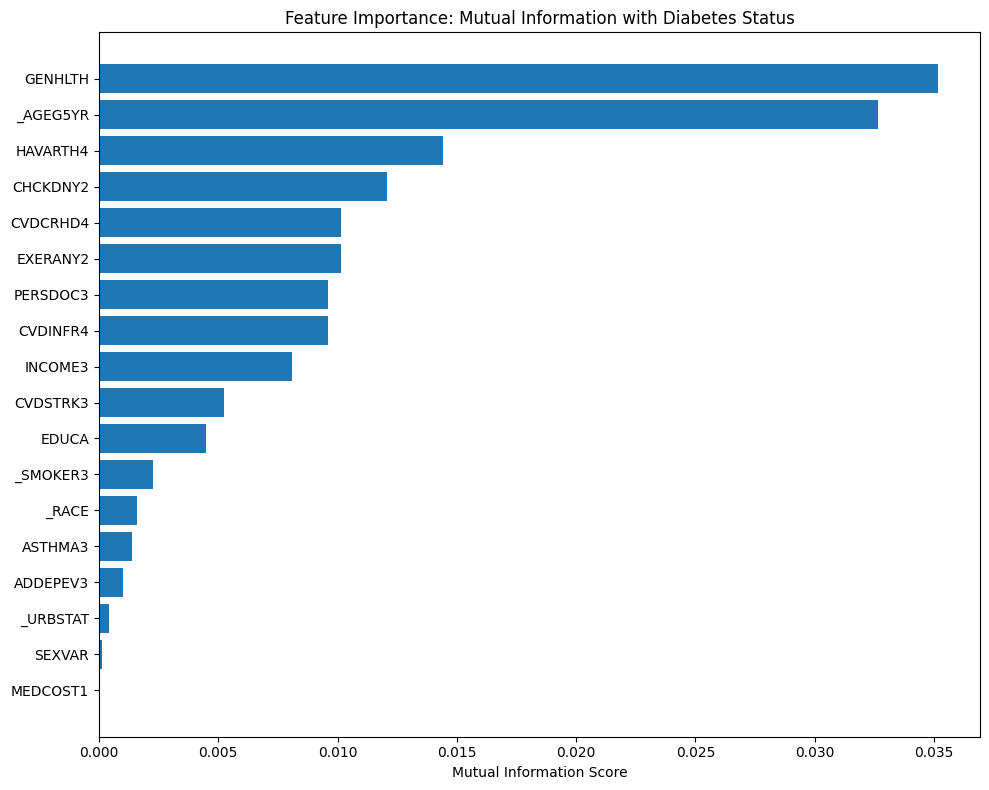

In [10]:
# Visualize mutual information scores
plt.figure(figsize=(10, 8))
plt.barh(range(len(mi_scores)), mi_scores['mi_score'])
plt.yticks(range(len(mi_scores)), mi_scores['feature'])
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance: Mutual Information with Diabetes Status')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Numeric Features

In [11]:
# Include missing indicator columns in numeric analysis
all_numeric_features = numeric_features + [f'{feat}_missing' for feat in numeric_features]

# Calculate correlations with target
numeric_corr = calculate_numeric_correlations(train_df, all_numeric_features, target_col)
print("Numeric Feature Correlations with Diabetes Status:")
print("="*60)
display(numeric_corr)

Numeric Feature Correlations with Diabetes Status:


,feature,correlation
0,_BMI5,0.184496
1,WTKG3,0.156102
2,_DRNKWK3,-0.065706
3,HTM4,-0.014655
4,HTM4_missing,-0.012301
5,_DRNKWK3_missing,-0.011536
6,_BMI5_missing,-0.010472
7,WTKG3_missing,-0.005541


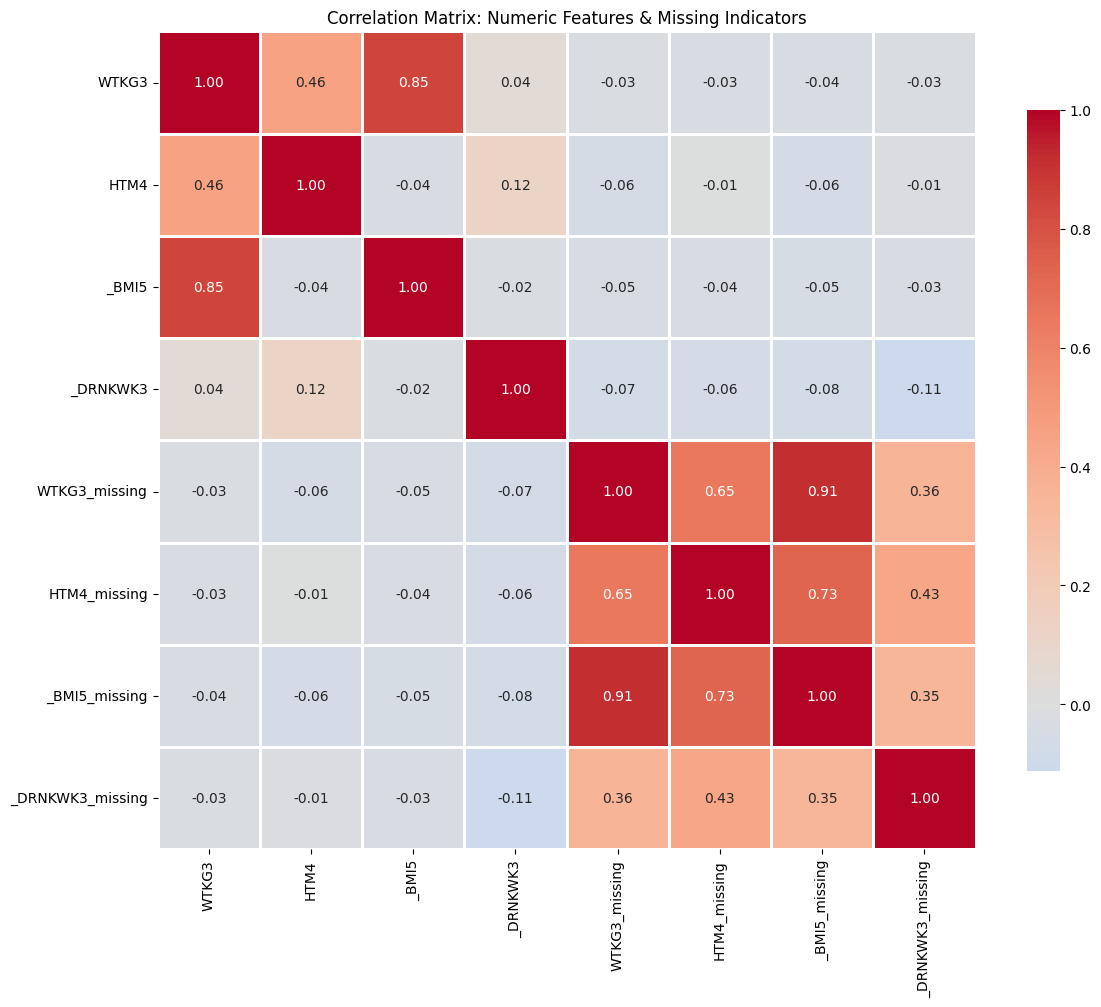


Highly Correlated Feature Pairs (|r| > 0.8):


,feature_1,feature_2,correlation
1,WTKG3_missing,_BMI5_missing,0.913456
0,WTKG3,_BMI5,0.845158


In [12]:
# Create correlation matrix heatmap for all numeric features
corr_matrix = train_df[all_numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Numeric Features & Missing Indicators')
plt.tight_layout()
plt.show()

# Highlight highly correlated pairs (|r| > 0.8)
print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
print("="*60)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)
    display(high_corr_df)
else:
    print("No feature pairs with |r| > 0.8")

### Multicollinearity Detection (VIF)

In [13]:
# Calculate VIF for all numeric features including missing indicators
vif_results = calculate_vif(train_df, all_numeric_features)
print("Variance Inflation Factor (VIF) for Numeric Features:")
print("="*60)
print("VIF > 10: Severe multicollinearity")
print("VIF 5-10: Moderate multicollinearity")
print("VIF < 5: Low multicollinearity")
print()
display(vif_results)

Variance Inflation Factor (VIF) for Numeric Features:
VIF > 10: Severe multicollinearity
VIF 5-10: Moderate multicollinearity
VIF < 5: Low multicollinearity



,feature,VIF
0,WTKG3,67.838219
1,_BMI5,64.616948
2,HTM4,22.635989
3,_BMI5_missing,8.322441
4,WTKG3_missing,6.705309
5,HTM4_missing,2.473619
6,_DRNKWK3_missing,1.410800
7,_DRNKWK3,1.168084


### Bivariate Analysis: Features vs. Target
#### Numeric Features Distribution by Diabetes Status

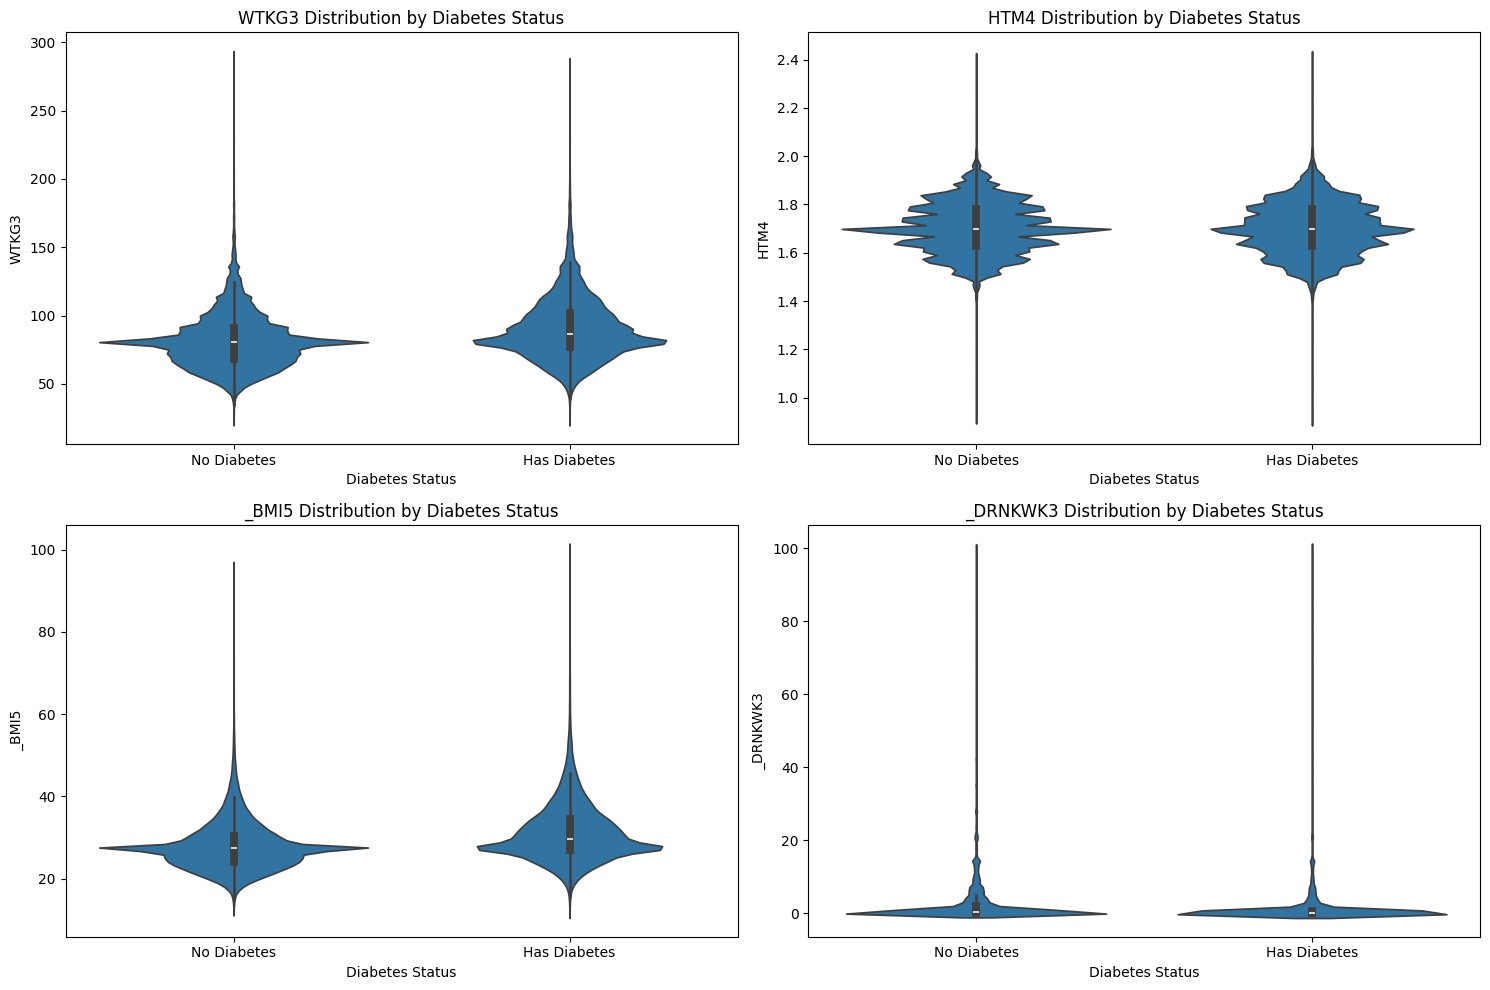

In [14]:
# Violin plots for numeric features stratified by diabetes status
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(numeric_features):
    sns.violinplot(data=train_df, x=target_col, y=feature, ax=axes[idx])
    axes[idx].set_xlabel('Diabetes Status')
    axes[idx].set_ylabel(feature)
    axes[idx].set_title(f'{feature} Distribution by Diabetes Status')
    # Fix: Set ticks first, then labels
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels(['No Diabetes', 'Has Diabetes'])

plt.tight_layout()
plt.show()

#### Categorical Features: Diabetes Prevalence Rates

In [15]:
# Analyze diabetes rates for top 5 categorical features by MI score
top_categorical = mi_scores[mi_scores['feature'].isin(categorical_features)].head(5)

print("Diabetes Prevalence Rates for Top 5 Categorical Features:")
print("="*60)

for feature in top_categorical['feature']:
    print(f"\n{feature}:")
    rates = calculate_diabetes_rate(train_df, feature, target_col)
    display(rates)

Diabetes Prevalence Rates for Top 5 Categorical Features:

HAVARTH4:


,HAVARTH4,diabetes_count,total_count,diabetes_rate
0,Yes,21318,91016,0.234223
1,Unknown,223,1330,0.167669
2,No,17943,172806,0.103833



CHCKDNY2:


,CHCKDNY2,diabetes_count,total_count,diabetes_rate
0,Yes,5732,13652,0.419865
1,Unknown,281,985,0.285279
2,No,33471,250515,0.133609



CVDCRHD4:


,CVDCRHD4,diabetes_count,total_count,diabetes_rate
0,Yes,5876,16289,0.360734
1,Unknown,778,2444,0.318331
2,No,32830,246419,0.133228



EXERANY2:


,EXERANY2,diabetes_count,total_count,diabetes_rate
0,No,14972,60965,0.245584
1,Unknown,162,736,0.220109
2,Yes,24350,203451,0.119685



PERSDOC3:


,PERSDOC3,diabetes_count,total_count,diabetes_rate
0,More than one,17162,89381,0.192009
1,"Yes, only one",20610,140290,0.146910
2,Unknown,292,2677,0.109077
3,No,1420,32804,0.043287


#### Ordinal Features: Diabetes Rate Trends

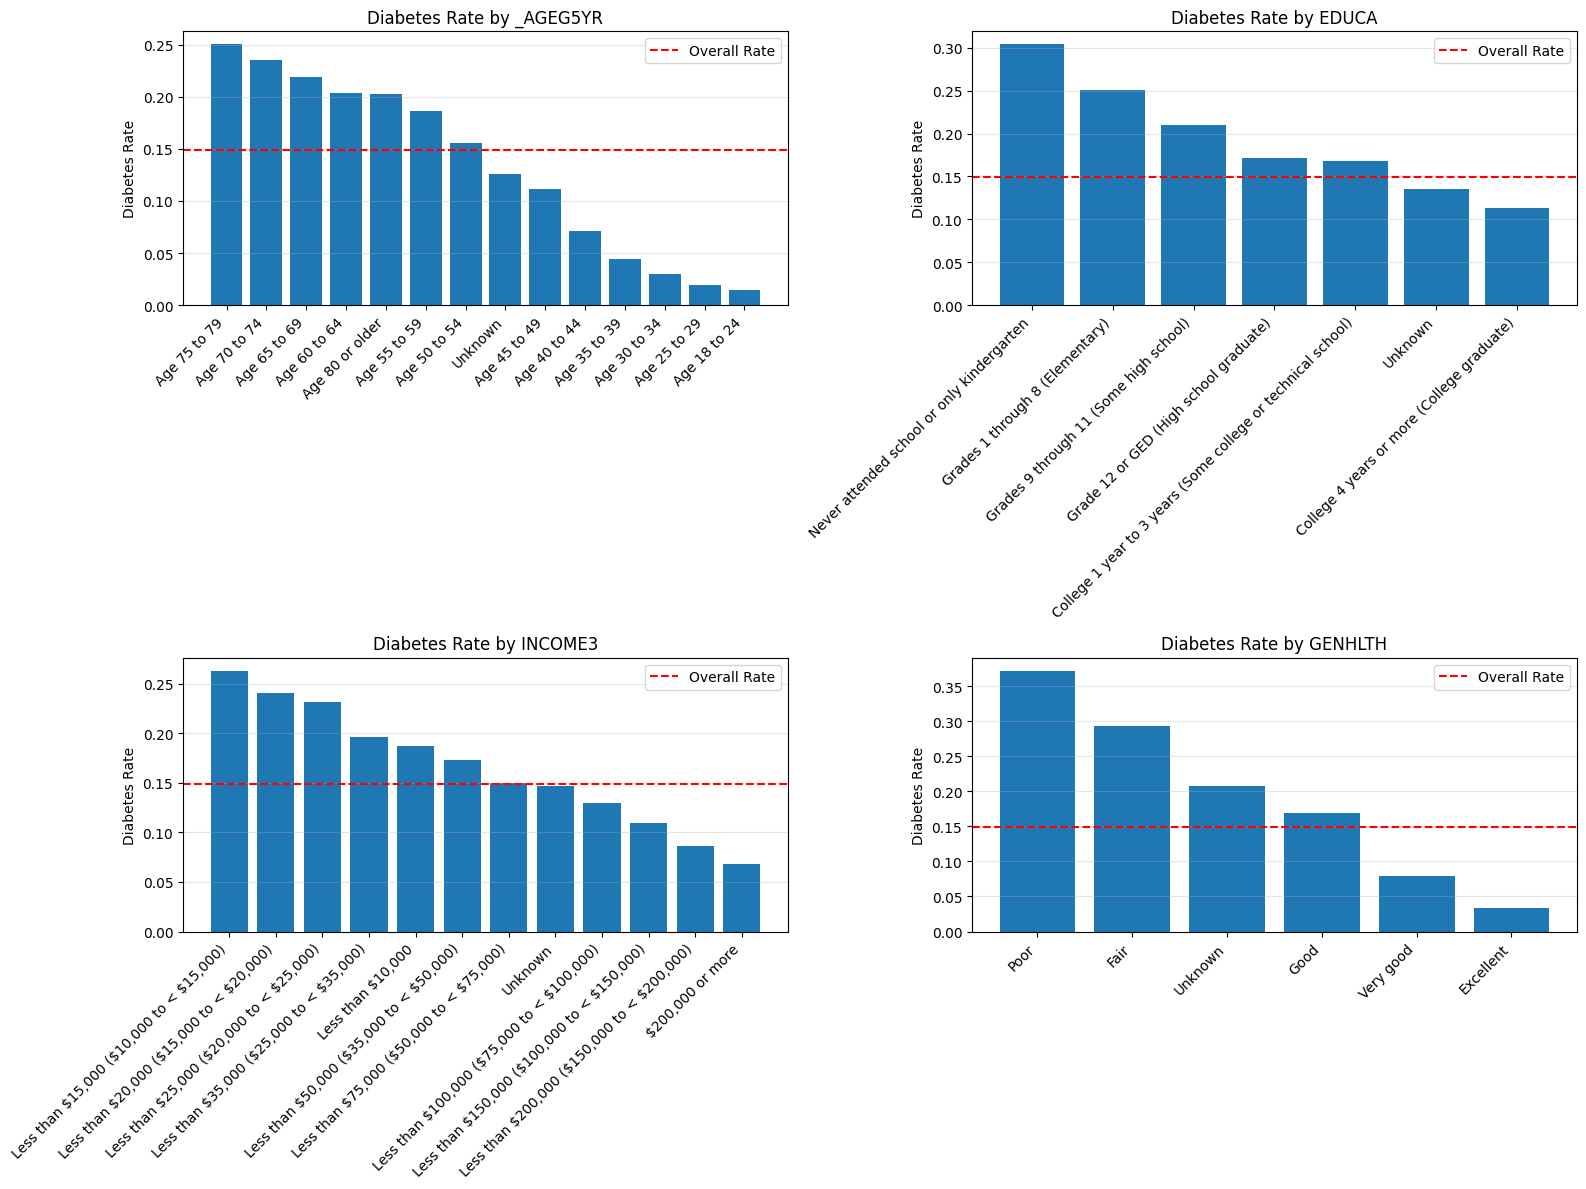

In [16]:
# Analyze diabetes rates across ordinal feature levels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(ordinal_features):
    rates = calculate_diabetes_rate(train_df, feature, target_col)
    
    # Create bar plot
    axes[idx].bar(range(len(rates)), rates['diabetes_rate'])
    axes[idx].set_xticks(range(len(rates)))
    axes[idx].set_xticklabels(rates[feature], rotation=45, ha='right')
    axes[idx].set_ylabel('Diabetes Rate')
    axes[idx].set_title(f'Diabetes Rate by {feature}')
    axes[idx].axhline(y=train_df[target_col].mean(), color='r', linestyle='--', label='Overall Rate')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Missing Indicator Analysis
Check if missingness patterns are informative for diabetes prediction.

In [17]:
# Analyze missing indicators
missing_indicator_cols = [f'{feat}_missing' for feat in numeric_features]

print("Missing Indicator Analysis:")
print("="*60)
print("\nDiabetes rates for records with vs. without missing values:\n")

for feature, indicator in zip(numeric_features, missing_indicator_cols):
    rates = calculate_diabetes_rate(train_df, indicator, target_col)
    rates[indicator] = rates[indicator].map({0: 'Not Missing', 1: 'Missing'})
    
    print(f"\n{feature}:")
    display(rates)
    
# Visualize missing indicator importance
print("\n" + "="*60)
print("Correlation of Missing Indicators with Target:")
missing_ind_corr = calculate_numeric_correlations(train_df, missing_indicator_cols, target_col)
display(missing_ind_corr)

Missing Indicator Analysis:

Diabetes rates for records with vs. without missing values:


WTKG3:


,WTKG3_missing,diabetes_count,total_count,diabetes_rate
0,Not Missing,36520,244302,0.149487
1,Missing,2964,20850,0.142158



HTM4:


,HTM4_missing,diabetes_count,total_count,diabetes_rate
0,Not Missing,37698,251431,0.149934
1,Missing,1786,13721,0.130165



_BMI5:


,_BMI5_missing,diabetes_count,total_count,diabetes_rate
0,Not Missing,36107,240548,0.150103
1,Missing,3377,24604,0.137254



_DRNKWK3:


,_DRNKWK3_missing,diabetes_count,total_count,diabetes_rate
0,Not Missing,35791,238140,0.150294
1,Missing,3693,27012,0.136717



Correlation of Missing Indicators with Target:


,feature,correlation
0,HTM4_missing,-0.012301
1,_DRNKWK3_missing,-0.011536
2,_BMI5_missing,-0.010472
3,WTKG3_missing,-0.005541


### Feature Selection Recommendations
Based on the EDA findings above, we can make informed decisions about which features to keep, remove, or consolidate.

In [18]:
print("FEATURE SELECTION RECOMMENDATIONS")
print("="*70)
print()

# 1. Identify low-importance categorical features (low MI score)
print("1. LOW IMPORTANCE FEATURES (Consider Removing)")
print("-"*70)
low_mi_threshold = 0.005  # Adjust based on distribution
low_importance = mi_scores[mi_scores['mi_score'] < low_mi_threshold]
if len(low_importance) > 0:
    print(f"   Features with MI score < {low_mi_threshold}:")
    for _, row in low_importance.iterrows():
        print(f"   - {row['feature']}: MI = {row['mi_score']:.6f}")
else:
    print(f"   No features with MI score < {low_mi_threshold}")
print()

# 2. Multicollinearity recommendations
print("2. MULTICOLLINEARITY (Choose One from Each Group)")
print("-"*70)
print("   Based on correlation analysis and VIF:")
print()
print("   WTKG3, HTM4, _BMI5 are likely highly correlated.")
print("   Recommendation:")
print("   - KEEP: _BMI5 (directly relevant to diabetes, contains both weight & height info)")
print("   - REMOVE: WTKG3 and HTM4 (redundant)")
print("   - ALTERNATIVE: Keep all three if using tree-based models (they handle collinearity)")
print()

# 3. Missing indicator recommendations
print("3. MISSING INDICATORS")
print("-"*70)
missing_ind_high_corr = missing_ind_corr[missing_ind_corr['correlation'].abs() > 0.01]
if len(missing_ind_high_corr) > 0:
    print("   Informative missing indicators (|correlation| > 0.01):")
    for _, row in missing_ind_high_corr.iterrows():
        print(f"   - {row['feature']}: r = {row['correlation']:.4f}")
    print("\n   Recommendation: KEEP these missing indicators")
else:
    print("   No missing indicators show strong correlation with target.")
    print("   Recommendation: Consider removing missing indicators if not informative")
print()

# 4. Top features to keep
print("4. TOP FEATURES TO PRIORITIZE")
print("-"*70)
print("   Categorical/Ordinal (Top 10 by MI score):")
for _, row in mi_scores.head(10).iterrows():
    print(f"   - {row['feature']}: MI = {row['mi_score']:.4f}")
print()
print("   Numeric (By absolute correlation):")
numeric_corr_sorted = numeric_corr[numeric_corr['feature'].isin(numeric_features)].copy()
numeric_corr_sorted['abs_corr'] = numeric_corr_sorted['correlation'].abs()
numeric_corr_sorted = numeric_corr_sorted.sort_values('abs_corr', ascending=False)
for _, row in numeric_corr_sorted.iterrows():
    print(f"   - {row['feature']}: r = {row['correlation']:.4f}")
print()

# 5. Summary
print("5. SUMMARY RECOMMENDATION")
print("-"*70)
print("   Next steps:")
print("   1. Remove WTKG3 and HTM4 if using linear models (keep _BMI5)")
print("   2. Consider removing features with MI score < 0.005")
print("   3. Keep informative missing indicators")
print("   4. Proceed with modeling using remaining features")
print("   5. Use feature importance from trained models for final selection")

FEATURE SELECTION RECOMMENDATIONS

1. LOW IMPORTANCE FEATURES (Consider Removing)
----------------------------------------------------------------------
   Features with MI score < 0.005:
   - EDUCA: MI = 0.004479
   - _SMOKER3: MI = 0.002245
   - _RACE: MI = 0.001588
   - ASTHMA3: MI = 0.001400
   - ADDEPEV3: MI = 0.001006
   - _URBSTAT: MI = 0.000410
   - SEXVAR: MI = 0.000148
   - MEDCOST1: MI = 0.000022

2. MULTICOLLINEARITY (Choose One from Each Group)
----------------------------------------------------------------------
   Based on correlation analysis and VIF:

   WTKG3, HTM4, _BMI5 are likely highly correlated.
   Recommendation:
   - KEEP: _BMI5 (directly relevant to diabetes, contains both weight & height info)
   - REMOVE: WTKG3 and HTM4 (redundant)
   - ALTERNATIVE: Keep all three if using tree-based models (they handle collinearity)

3. MISSING INDICATORS
----------------------------------------------------------------------
   Informative missing indicators (|correlation

In [19]:
## Final feature selection